<a href="https://colab.research.google.com/github/jidnyasanaik123/Drug_Discovery_DeepLearning/blob/main/Drug_Discovery_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI-Powered Drug Discovery using Deep Learning

This notebook demonstrates a deep learning approach using Graph Neural Networks (GNNs) and CNNs for predicting drug-target interactions, specifically IC50 values. Dataset used: BindingDB from TDC.

In [1]:
!pip install pytdc torch rdkit-pypi torch-geometric pandas matplotlib seaborn scikit-learn plotly

In [2]:
# Install necessary packages (uncomment and run if needed)
# !pip install tdc torch_geometric rdkit pandas matplotlib seaborn scikit-learn torch plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tdc.single_pred import ADME
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool


In [3]:
# Load dataset from TDC
from tdc.multi_pred import DTI
data = DTI(name='bindingdb_ic50').get_data()

# Keep a sample for quick prototype
data = data.sample(2000, random_state=42).reset_index(drop=True)
data.head()

Downloading...
100%|██████████| 839M/839M [00:18<00:00, 44.7MiB/s]
Loading...
Done!


,Drug_ID,Drug,Target_ID,Target,Y
0,24966889.0,C[C@H](C[C@H](O)[C@@H](N)CN1CC(=O)N(c2ccccc2Cl...,Q6DLS0,MDGWRRMPRWGLLLLLWGSCTFGLPTDTTTFKRIFLKRMPSIRESL...,2.1
1,118069152.0,NC(=O)c1c(-c2cccc(F)c2)nn2c1CN(C(=O)NC1C3CC4CC...,P48730,MELRVGNRYRLGRKIGSGSFGDIYLGTDIAAGEEVAIKLECVKTKH...,10.0
2,53363139.0,COc1cc2ncnc(N3CCCC(c4ccccc4)C3)c2cc1OCc1ccccn1,Q9QYJ6,MEDGPSNNASCFRRLTECFLSPSLTDEKVKAYLSLHPQVLDEFVSE...,3200.0
3,51003550.0,CC1CC(=O)c2ccc(N3CCN(C)CC3)cc2N1S(=O)(=O)c1ccc...,P14416,MDPLNLSWYDDDLERQNWSRPFNGSDGKADRPHYNYYATLLTLLIA...,136.0
4,124081627.0,CNC(=O)N1C(=O)N(c2cccc(C(F)F)c2)C2=C(C(=O)CC2)...,P08246,MTLGRRLACLFLACVLPALLLGGTALASEIVGGRRARPHAWPFMVS...,1.1


In [4]:
# Tokenize SMILES and target
from rdkit import Chem
from rdkit.Chem import AllChem

# Convert SMILES to Morgan Fingerprints using RDKit
def smiles_to_morgan_fp(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    else:
        return np.zeros((nBits,))

# Apply to the drug column
data['drug_fp'] = data['Drug'].apply(lambda x: smiles_to_morgan_fp(x))
drug_features = np.stack(data['drug_fp'].values)

# One-hot encode targets
target_features = pd.get_dummies(data['Target']).values

# Get labels
labels = data['Y'].values

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class DrugTargetDataset(Dataset):
    def __init__(self, drug_feats, target_feats, labels):
        self.drug_feats = torch.tensor(drug_feats, dtype=torch.float32)
        self.target_feats = torch.tensor(target_feats, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.drug_feats[idx], self.target_feats[idx], self.labels[idx]


In [6]:
class DrugTargetModel(nn.Module):
    def __init__(self, drug_dim, target_dim):
        super().__init__()
        self.drug_fc = nn.Sequential(
            nn.Linear(drug_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.target_fc = nn.Sequential(
            nn.Linear(target_dim, 128),
            nn.ReLU()
        )
        self.output = nn.Linear(128 + 128, 1)

    def forward(self, drug_x, target_x):
        drug_embed = self.drug_fc(drug_x)
        target_embed = self.target_fc(target_x)
        combined = torch.cat([drug_embed, target_embed], dim=1)
        return self.output(combined)


In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
results = []

for train_idx, val_idx in kf.split(drug_features):
    print(f"Training Fold {fold}...")
    train_ds = DrugTargetDataset(drug_features[train_idx], target_features[train_idx], labels[train_idx])
    val_ds = DrugTargetDataset(drug_features[val_idx], target_features[val_idx], labels[val_idx])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    model = DrugTargetModel(drug_dim=drug_features.shape[1], target_dim=target_features.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(10):
        model.train()
        for d, t, y in train_loader:
            optimizer.zero_grad()
            preds = model(d, t)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

    # Validation
       # Validation
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for d, t, y in val_loader:
            preds = model(d, t)
            val_preds.extend(preds.numpy().flatten())
            val_true.extend(y.numpy().flatten())

    rmse = mean_squared_error(val_true, val_preds) ** 0.5
    print(f"Fold {fold} RMSE: {rmse:.4f}")
    results.append(rmse)
    fold += 1

print(f"Average RMSE: {np.mean(results):.4f}")


Training Fold 1...
Fold 1 RMSE: 502587.4995
Training Fold 2...
Fold 2 RMSE: 82599.8598
Training Fold 3...
Fold 3 RMSE: 93876.8157
Training Fold 4...
Fold 4 RMSE: 316403.5394
Training Fold 5...
Fold 5 RMSE: 57530.1750
Average RMSE: 210599.5779


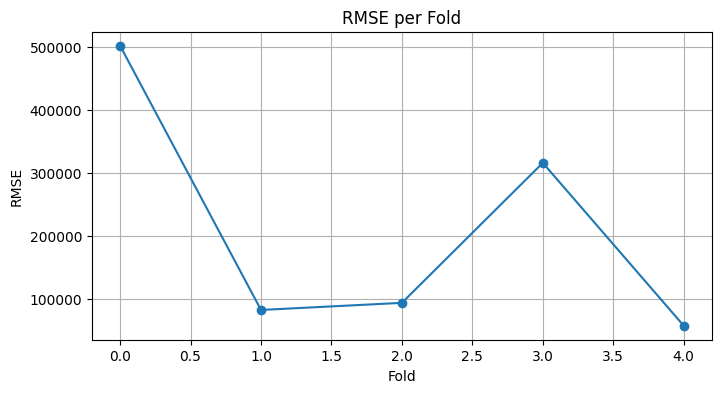

In [8]:
# Simple plot
plt.figure(figsize=(8, 4))
plt.plot(results, marker='o')
plt.title("RMSE per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.grid()
plt.show()
